In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import re
from statsmodels.tsa.stattools import adfuller #used to check stationarity of data#
from statsmodels.tsa.arima.model import ARIMA #arima model used for time series analysis#
from pmdarima import auto_arima #optimises the arima parameters for a specific dataset#

# Tools

In [2]:
def transform_stationary(data):
    """
        transforms non stationary data to stationary data for time series analysis

        inputs:
            data : non stationary data

        Outputs:
            X    : transformed stationary data
    """

    log_data = np.log(data)
    rolmean = log_data.rolling(window=30).mean()
    X = log_data - rolmean
    X.dropna(inplace=True)
    return X

# Data Information

In [3]:
main_data = pd.read_csv('sales_volumes.csv')
main_data['date'] = pd.to_datetime(main_data['date'])
main_data['volume'] = main_data['volume'].astype('float64')
start_date = datetime(2019,12,31)
end_date = datetime(2020,6,29)
main_data.head(10)

,invoice_id,product_code,description,volume,date,unit_price,customer_id
0,544601,22440,BALLOON WATER BOMB PACK OF 35,20.0,2019-12-31,10.08,16638.0
1,544601,21829,DINOSAUR KEYRINGS ASSORTED,36.0,2019-12-31,5.04,16638.0
2,544601,23230,WRAP ALPHABET DESIGN,25.0,2019-12-31,10.08,16638.0
3,544601,22492,MINI PAINT SET VINTAGE,36.0,2019-12-31,15.60,16638.0
4,544602,22998,TRAVEL CARD WALLET KEEP CALM,24.0,2019-12-31,10.08,13767.0
5,544602,84879,ASSORTED COLOUR BIRD ORNAMENT,32.0,2019-12-31,40.56,13767.0
6,544602,22423,REGENCY CAKESTAND 3 TIER,16.0,2019-12-31,262.80,13767.0
7,544605,84755,COLOUR GLASS T-LIGHT HOLDER HANGING,144.0,2019-12-31,13.20,17512.0
8,544606,85099B,JUMBO BAG RED RETROSPOT,100.0,2019-12-31,39.60,14520.0
9,544607,22084,PAPER CHAIN KIT EMPIRE,6.0,2019-12-31,70.80,13862.0


In [4]:
main_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38783 entries, 0 to 38782
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   invoice_id    38783 non-null  object        
 1   product_code  38783 non-null  object        
 2   description   38770 non-null  object        
 3   volume        38783 non-null  float64       
 4   date          38783 non-null  datetime64[ns]
 5   unit_price    38783 non-null  float64       
 6   customer_id   31050 non-null  float64       
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 2.1+ MB


In [5]:
main_data['description'].value_counts()

PARTY BUNTING                         1136
WHITE HANGING HEART T-LIGHT HOLDER    1063
REGENCY CAKESTAND 3 TIER              1062
JUMBO BAG RED RETROSPOT               1021
LUNCH BAG RED RETROSPOT                826
                                      ... 
mailout                                  4
?                                        3
WRAP  VINTAGE DOILEY                     2
damages                                  2
damaged                                  1
Name: description, Length: 116, dtype: int64

### Example
used to show an explain processes taken in order to make forcast
complete algorithm at the end of the notebook and alogrithm.py

In [6]:
product_name = 'PARTY BUNTING'
sub_data = main_data[main_data['description']==product_name]
sub_data.head(10)

,invoice_id,product_code,description,volume,date,unit_price,customer_id
77,544657,47566,PARTY BUNTING,4.0,2019-12-31,118.80,14895.0
98,544663,47566,PARTY BUNTING,6.0,2019-12-31,118.80,18188.0
187,544684,47566,PARTY BUNTING,6.0,2019-12-31,258.96,NaN
338,544776,47566,PARTY BUNTING,8.0,2020-01-01,258.96,NaN
370,544790,47566,PARTY BUNTING,4.0,2020-01-01,118.80,16940.0
376,544794,47566,PARTY BUNTING,50.0,2020-01-01,99.60,13854.0
406,544806,47566,PARTY BUNTING,4.0,2020-01-01,118.80,15932.0
409,544810,47566,PARTY BUNTING,4.0,2020-01-01,118.80,17675.0
535,544894,47566,PARTY BUNTING,4.0,2020-01-02,118.80,15805.0
546,544900,47566,PARTY BUNTING,4.0,2020-01-02,118.80,15121.0


In [7]:
formated_data = pd.DataFrame(columns=['date','volume'])

product_code = sub_data['product_code'].unique()[0]
description = sub_data['description'].unique()[0]

#getting volume sales for the day,including missing dates#
curr_date = start_date

while curr_date <= end_date:
    x = sub_data[sub_data['date']==curr_date]
    vol = 0

    if x.shape[0]>0:
        vol = sum(x['volume'])

    row = {'date':curr_date,'volume':vol}
    formated_data = formated_data.append(row,ignore_index=True)
    curr_date+=timedelta(days=1)

formated_data.set_index('date',inplace=True)
formated_data.index = pd.DatetimeIndex(formated_data.index.values,freq=formated_data.index.inferred_freq)
formated_data.head(10)


,volume
2019-12-31,16.0
2020-01-01,70.0
2020-01-02,25.0
2020-01-03,19.0
2020-01-04,0.0
2020-01-05,27.0
2020-01-06,71.0
2020-01-07,0.0
2020-01-08,30.0
2020-01-09,75.0


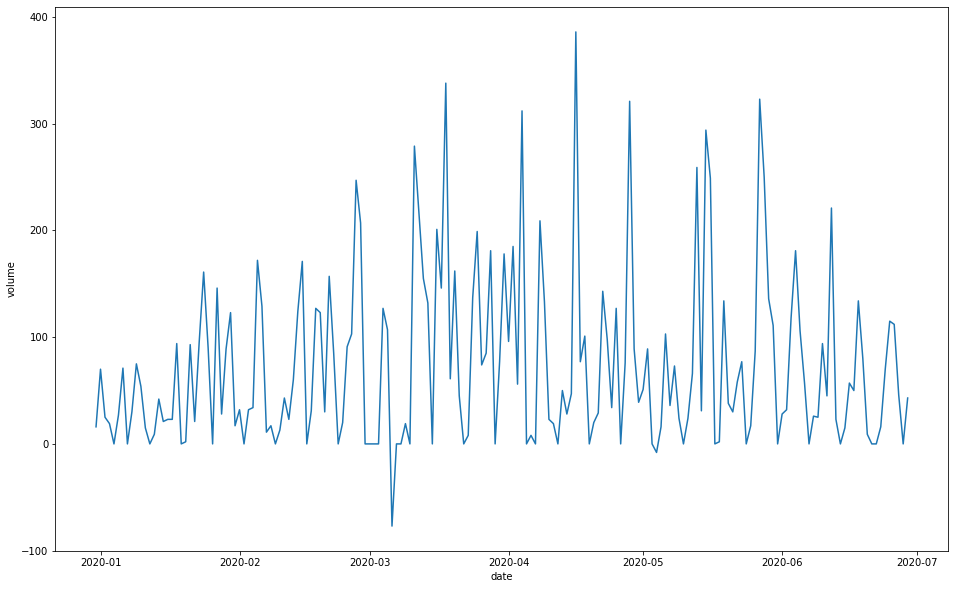

In [8]:
#based on plot we can see that the data is stationary#
fig,ax = plt.subplots(1,figsize = (16,10))
ax.plot(formated_data.index,formated_data['volume'])
ax.set_ylabel('volume')
ax.set_xlabel('date')
plt.show()

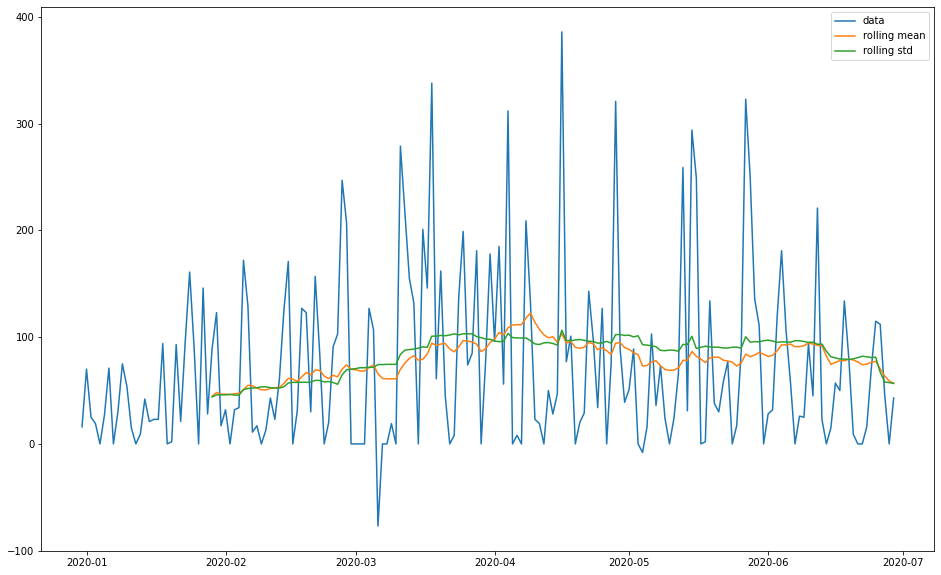

In [9]:
fig,ax = plt.subplots(1,figsize = (16,10))
#checking mean every one month days#
rolmean = formated_data.rolling(window=30).mean()
rolstd = formated_data.rolling(window=30).std()
ax.plot(formated_data.index,formated_data['volume'],label='data')
ax.plot(rolmean,label='rolling mean')
ax.plot(rolstd,label='rolling std')
plt.legend(loc='best')
plt.show()

In [10]:
#adding in the z score to determine if a point is an outlier or not#
formated_data['Z_score'] = (formated_data['volume'] - formated_data['volume'].mean())/formated_data['volume'].std()
formated_data.head()

,volume,Z_score
2019-12-31,16.0,-0.706187
2020-01-01,70.0,-0.043871
2020-01-02,25.0,-0.595801
2020-01-03,19.0,-0.669391
2020-01-04,0.0,-0.902428


In [11]:
#outliers#
outlier = formated_data[np.abs(formated_data['Z_score']) > 3]
outlier.head(10)

,volume,Z_score
2020-03-18,338.0,3.243175
2020-04-16,386.0,3.831900
2020-04-28,321.0,3.034668
2020-05-27,323.0,3.059198


In [12]:
#replacing outliers using iterpolation#
formated_data['volume'].loc[np.abs(formated_data['Z_score'] > 3)] = np.nan
formated_data['volume'].interpolate(method='polynomial',order=2,axis=0,inplace=True)
formated_data = formated_data.drop(['Z_score'],axis=1)

In [14]:
formated_data = formated_data.fillna(method='pad') #if not possible to find all points using interpolation#
formated_data

,volume
2019-12-31,16.0
2020-01-01,70.0
2020-01-02,25.0
2020-01-03,19.0
2020-01-04,0.0
...,...
2020-06-25,115.0
2020-06-26,112.0
2020-06-27,46.0
2020-06-28,0.0


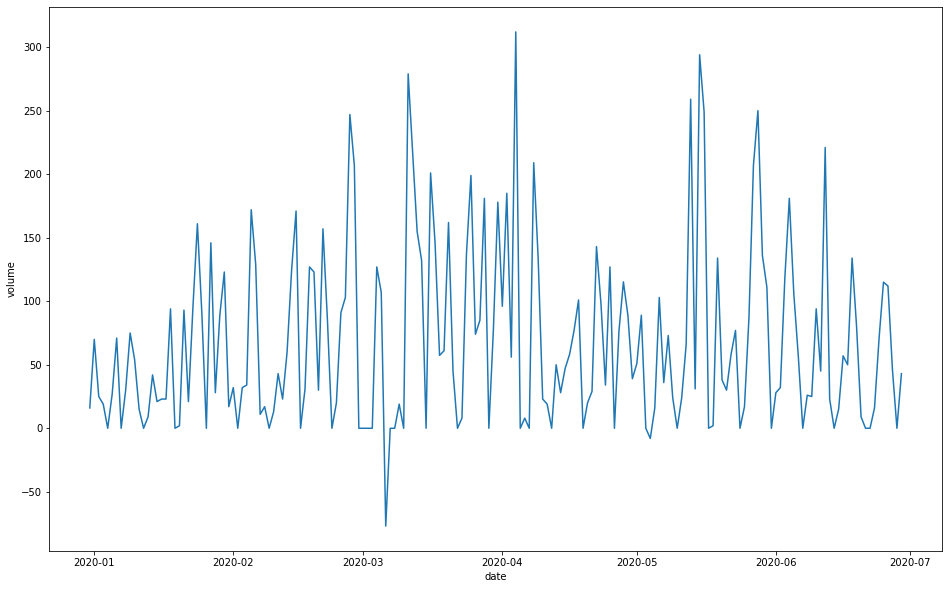

In [15]:
#plot with replaced outliers. data still maintains similar pattern#
fig,ax = plt.subplots(1,figsize = (16,10))
ax.plot(formated_data.index,formated_data['volume'])
ax.set_ylabel('volume')
ax.set_xlabel('date')
plt.show()

In [16]:
#checking mean every one month#
rolmean = formated_data.rolling(window=30).mean()
rolstd = formated_data.rolling(window=30).std()

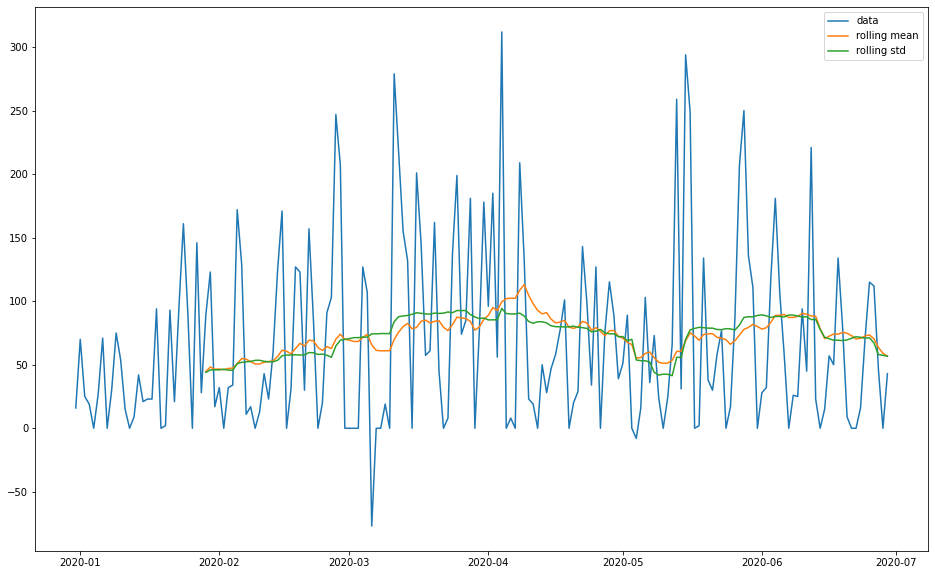

In [17]:
fig,ax = plt.subplots(1,figsize = (16,10))
ax.plot(formated_data.index,formated_data['volume'],label='data')
ax.plot(rolmean,label='rolling mean')
ax.plot(rolstd,label='rolling std')
plt.legend(loc='best')
plt.show()

In [18]:
test_stat,p,no_lag,no_obser,crit_values,icbest = adfuller(formated_data['volume'],autolag='AIC')

In [19]:
#since p < 0.05 accept hypothesis#
p

0.03412006362425631

In [20]:
train = formated_data.iloc[:-30]
test = formated_data.iloc[-30:]

In [21]:
#used to find optimal parameters for the arima model#
param_fit = auto_arima(train,trace=True,suppress_warnings=True)
p,d,q=param_fit.get_params()['order']

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1743.280, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1743.265, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1737.902, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1737.299, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1840.254, Time=0.00 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1739.283, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1739.282, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1741.281, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1798.900, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0] intercept
Total fit time: 0.382 seconds


In [22]:
model = ARIMA(train['volume'].astype(float),order=(p,d,q))
model = model.fit()

In [23]:
start = train.index[-1] + timedelta(days=1)
end = start + timedelta(days=29)
pred = model.predict(start=start,end=end)

In [25]:
param_fit = auto_arima(formated_data,trace=False,suppress_warnings=True)
p,d,q=param_fit.get_params()['order']

model = ARIMA(formated_data.astype(float),order=(p,d,q))
model = model.fit()

start = formated_data.index[-1] + timedelta(days=1)
end = start + timedelta(days=99)
pred = model.predict(start=start,end=end)

In [26]:
pred

2020-06-30    65.850455
2020-07-01    68.437427
2020-07-02    68.437427
2020-07-03    68.437427
2020-07-04    68.437427
                ...    
2020-10-03    68.437427
2020-10-04    68.437427
2020-10-05    68.437427
2020-10-06    68.437427
2020-10-07    68.437427
Freq: D, Name: predicted_mean, Length: 100, dtype: float64

# <center> Complete Algorithm

In [2]:
main_data = pd.read_csv('sales_volumes.csv')
baseline = pd.read_csv('baseline.csv')
main_data['date'] = pd.to_datetime(main_data['date'])
main_data['volume'] = main_data['volume'].astype('float64')
start_date = datetime(2019,12,31)
end_date = datetime(2020,6,29)

product_list = main_data['description'].dropna().unique()
output = pd.DataFrame(columns=['product_code','baseline','predicted','trending'])

for product_name in product_list:
    sub_data = main_data[main_data['description']==product_name]
    product_code = sub_data['product_code'].unique()[0]
    sub_data = main_data[main_data['description']==product_name]
    formated_data = pd.DataFrame(columns=['date','volume'])

    #getting volume sales for the day,including missing dates#
    curr_date = start_date

    while curr_date <= end_date:
        x = sub_data[sub_data['date']==curr_date]
        vol = 0

        if x.shape[0]>0:
            vol = sum(x['volume'])

        row = {'date':curr_date,'volume':vol}
        formated_data = formated_data.append(row,ignore_index=True)
        curr_date+=timedelta(days=1)

    formated_data.set_index('date',inplace=True)
    formated_data.index = pd.DatetimeIndex(formated_data.index.values,freq=formated_data.index.inferred_freq)

    #replacing outliers using interpolation#
    formated_data['Z_score'] = (formated_data['volume'] - formated_data['volume'].mean())/formated_data['volume'].std()
    formated_data['volume'].loc[np.abs(formated_data['Z_score'] > 3)] = np.nan
    formated_data['volume'].interpolate(method='polynomial',order=2,axis=0,inplace=True)
    formated_data = formated_data.drop(['Z_score'],axis=1)
    formated_data = formated_data.fillna(value=formated_data.mean())
    
    #fitting the arima model and getting predictions#
    param_fit = auto_arima(formated_data,trace=False,suppress_warnings=True)
    p,d,q=param_fit.get_params()['order']

    if p+d+q == 0: #if optimal parameters cannot be found use default values (1,1,1)#
        p = 1
        d = 1
        q = 1

    model = ARIMA(formated_data.astype(float),order=(p,d,q))
    model = model.fit()

    start = formated_data.index[-1] + timedelta(days=1)
    end = start + timedelta(days=99)
    pred = model.predict(start=start,end=end)

    #getting total sales for next 4 weeks#
    pred_data = pd.DataFrame(pred)
    end = start + timedelta(weeks=4)
    predicted_volume = pred_data[pred_data.index<=end].sum()[0]
    
    base_data = baseline['baseline_forecast'].loc[baseline['product_code']==product_code]
    base_volume = 0

    #getting baseline volume#
    if base_data.shape[0] ==1:
        base_volume = base_data.values[0]
    
    #determining if product trending#
    trending = False

    if base_volume!=0:
        percent = ((predicted_volume-base_volume)/base_volume)*100
        if percent>=100:
            trending=True
        else:
            trending=False
    
    record = {'product_code':product_code,'baseline':base_volume,'predicted':predicted_volume,'trending':trending}
    output = output.append(record,ignore_index=True)

output.set_index('product_code',inplace=True)
output.to_csv('output.csv')

/home/gideon/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gideon/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/gideon/.local/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/gideon/.local/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/gideon/.local/lib/python3.8/si